In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown, Latex
from tabpfn import TabPFNClassifier, TabPFNRegressor
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import cross_val_score
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor
import torch
if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')
from tabpfn_extensions import unsupervised
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from AutoClean import AutoClean
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:


# 文件路径列表
file_paths = [
    'resampled_data.csv',

]

# 读取所有CSV文件并存储在列表中
dfs = [pd.read_csv(file) for file in file_paths]

# 合并所有的数据框（默认按行合并）
combined_df = pd.concat(dfs, ignore_index=True)

# 获取倒数三列的列名
last_three_columns = combined_df.columns

# 遍历倒数三列，输出每列的类别及各类别的数量
for column in last_three_columns:
    print(f"Column: {column}")
    print(combined_df[column].value_counts())  # 输出类别及其数量
    print("-" * 30)  # 分隔线



# 读取Excel文件
df = pd.read_csv('resampled_data.csv')
# 显示数据框的前几行以便确认数据结构
display(df.head())
data=df

print("df 中的缺失值数量:", df.isnull().sum().sum())
# 删除含有缺失值的行
df = df.dropna()
print("df 中的缺失值数量:", df.isnull().sum().sum())


Column: pkSeqID
pkSeqID
48170      1
3014360    1
1794593    1
1941859    1
3050108    1
          ..
1358253    1
906567     1
880702     1
249949     1
3668522    1
Name: count, Length: 50534, dtype: int64
------------------------------
Column: stime
stime
1.526344e+09    6
1.526876e+09    6
1.526345e+09    5
1.528099e+09    5
1.526348e+09    5
               ..
1.528085e+09    1
1.528081e+09    1
1.528085e+09    1
1.528081e+09    1
1.529381e+09    1
Name: count, Length: 44838, dtype: int64
------------------------------
Column: flgs_number
flgs_number
1    38195
2     9624
6     1464
5     1226
3       18
7        5
8        1
4        1
Name: count, dtype: int64
------------------------------
Column: proto_number
proto_number
3    26951
1    22560
4      961
2       62
Name: count, dtype: int64
------------------------------
Column: sport
sport
771      954
51005    129
1216     128
62819    127
41840    125
        ... 
51228      1
35168      1
18128      1
935        1
35066    

,pkSeqID,stime,flgs_number,proto_number,sport,dport,pkts,bytes,state_number,ltime,...,state_TST,state_URP,saddr_1,saddr_2,saddr_3,saddr_4,daddr_1,daddr_2,daddr_3,daddr_4
0,48170,1.528081e+09,2,1,29265,80,5,770,3,1.528081e+09,...,False,False,11000000,10101000,1100100,10010011,11000000,10101000,1100100,111
1,239682,1.528081e+09,1,1,49782,80,3,274,1,1.528081e+09,...,False,False,11000000,10101000,1100100,10010110,11000000,10101000,1100100,11
2,292697,1.528081e+09,2,1,56676,80,5,770,3,1.528081e+09,...,False,False,11000000,10101000,1100100,10010011,11000000,10101000,1100100,111
3,633498,1.528085e+09,1,3,3658,80,7,420,4,1.528085e+09,...,False,False,11000000,10101000,1100100,10010100,11000000,10101000,1100100,110
4,210673,1.528081e+09,1,1,38427,80,3,274,1,1.528081e+09,...,False,False,11000000,10101000,1100100,10010110,11000000,10101000,1100100,11


df 中的缺失值数量: 0
df 中的缺失值数量: 0


In [4]:
# 分离因变量（目标变量）和自变量（特征）
y = df.loc[:, 'category']  # 选择 'Depression' 列作为因变量
X = df.drop(columns= ['category','attack', 'category', 'subcategory','stime','pkSeqID'])  # 删除 'Depression' 列，其余列作为自变量

# 对因变量进行编码
le = LabelEncoder()
y = le.fit_transform(y)

# 将 y 转换为 Pandas Series 以便使用 .head()
y = pd.Series(y, name='category')

# 对自变量中的非数值列进行编码
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype('category').cat.codes

# 显示处理后的因变量和自变量
display(y.head())
display(X.head())


0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32

,flgs_number,proto_number,sport,dport,pkts,bytes,state_number,ltime,seq,dur,...,state_TST,state_URP,saddr_1,saddr_2,saddr_3,saddr_4,daddr_1,daddr_2,daddr_3,daddr_4
0,2,1,29265,80,5,770,3,1.528081e+09,46693,32.113567,...,False,False,11000000,10101000,1100100,10010011,11000000,10101000,1100100,111
1,1,1,49782,80,3,274,1,1.528081e+09,238205,0.192546,...,False,False,11000000,10101000,1100100,10010110,11000000,10101000,1100100,11
2,2,1,56676,80,5,770,3,1.528081e+09,29067,33.381279,...,False,False,11000000,10101000,1100100,10010011,11000000,10101000,1100100,111
3,1,3,3658,80,7,420,4,1.528085e+09,16221,26.117819,...,False,False,11000000,10101000,1100100,10010100,11000000,10101000,1100100,110
4,1,1,38427,80,3,274,1,1.528081e+09,209196,0.074902,...,False,False,11000000,10101000,1100100,10010110,11000000,10101000,1100100,11


In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


# 1. Lasso特征选择
# 数据标准化
scaler = StandardScaler()                      # 创建标准化器实例
x_scaled = scaler.fit_transform(X)             # 对特征进行标准化处理

# 使用网格搜索找到最佳的alpha值
lasso = Lasso(random_state=42)                 # 创建Lasso回归模型，设置随机种子
parameters = {'alpha': np.logspace(-2.5, 0, 50)}  # 调整范围
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)  # 创建网格搜索对象
lasso_regressor.fit(x_scaled, y)               # 拟合模型，找到最佳alpha值

# 获取最佳模型
best_lasso = lasso_regressor.best_estimator_   # 提取具有最佳alpha值的Lasso模型

# 获取特征重要性
lasso_importance = np.abs(best_lasso.coef_)    # 获取Lasso系数的绝对值作为特征重要性
lasso_features = X.columns[lasso_importance > 0] # 选择系数不为0的特征

print("Lasso选择的特征数量:", len(lasso_features))  # 打印Lasso选择的特征数量
print("Lasso选择的特征:", list(lasso_features))    # 打印Lasso选择的特征列表
# 使用Lasso选择的特征
X_lasso = X[lasso_features]  # 只保留Lasso选择的特征


# 检查最佳 alpha 值
print("Best alpha:", lasso_regressor.best_params_['alpha'])



Lasso选择的特征数量: 15
Lasso选择的特征: ['sport', 'ltime', 'seq', 'mean', 'stddev', 'TnP_PerProto', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'state_CON', 'state_FIN', 'state_REQ', 'state_URP', 'daddr_2', 'daddr_3']
Best alpha: 0.026203985288583486


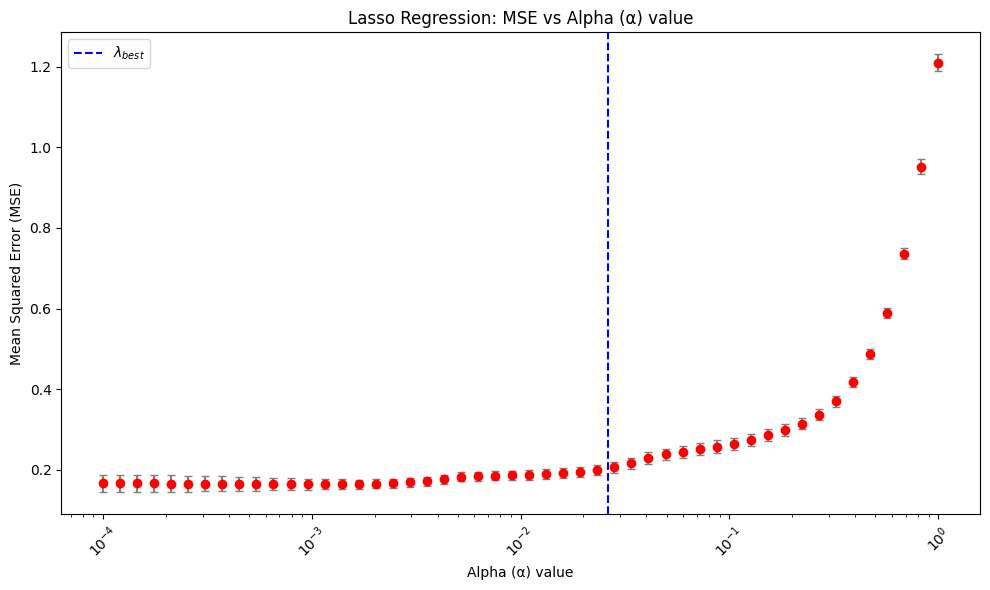

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt

# 假设 X 和 y 已经定义
# 示例：X = pd.DataFrame(...) , y = ...

# 数据标准化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

# 定义一组 alpha 值的范围
alphas = np.logspace(-4, 0, 50)  # 生成 50 个在 10^-4 到 10^0 之间的 alpha 值

# 使用交叉验证的 LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=42), random_state=42)
lasso_cv.fit(x_scaled, y)

# 计算均方误差路径和标准差
mse_path = lasso_cv.mse_path_.mean(axis=1)  # 每个 alpha 的均方误差
mse_std = lasso_cv.mse_path_.std(axis=1)    # 每个 alpha 的均方误差的标准差

# 绘图
plt.figure(figsize=(10, 6))
plt.errorbar(lasso_cv.alphas_, mse_path, yerr=mse_std, fmt='o', color='red', ecolor='gray', capsize=3)
plt.axvline(lasso_regressor.best_params_['alpha'], linestyle='--', color='blue', label=r'$\lambda_{best}$')  # 标注 1-SE 规则的 alpha
plt.xscale('log')  # 使用对数刻度显示 alpha 值
plt.xlabel('Alpha (α) value')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Regression: MSE vs Alpha (α) value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('MSE与正则化参数.pdf', format='pdf')  # 保存为 PDF 格式
plt.show()


In [7]:
# # 绘制系数路径图
# coefs = []
# for a in alphas:
#     lasso = Lasso(alpha=a, max_iter=10000)
#     lasso.fit(x_scaled, y)
#     coefs.append(lasso.coef_)

# # 绘制系数路径
# plt.figure(figsize=(10, 6))
# ax = plt.gca()

# # 使用 log scale 显示 alpha 值
# ax.plot(np.log10(alphas), coefs)
# plt.xlabel('Log Lambda')
# plt.ylabel('Coefficients')
# plt.title('Lasso Paths')
# plt.axis('tight')

# # 标注最佳 alpha 和 1-SE 规则的 alpha
# plt.axvline(np.log10(lasso_regressor.best_params_['alpha']), linestyle='--', color='black', label=r'$\lambda_{best}$')  # 标注最佳 alpha
# plt.legend()
# plt.show()

In [8]:
# 导入必要的库
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# 假设 x 和 y 已经定义
# x: 特征数据 (DataFrame 或二维数组)
# y: 目标变量 (一维数组)
# 标准化特征数据
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)  # 对特征进行标准化处理

# 选择基础模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # 创建随机森林分类器作为基础模型

# 初始化RFE
# 选择特征数量可以根据需要调整
n_features_to_select = min(30, len(X.columns))  # 选择10个特征或全部特征（如果特征总数少于10）

rfe = RFE(
    estimator=rf,                            # 使用随机森林作为评估器
    n_features_to_select=n_features_to_select,  # 设置要选择的特征数量
    step=1,                                  # 每次移除一个特征
    verbose=1                                # 启用详细输出
)

# 进行特征选择
rfe.fit(x_scaled, y)  # 拟合RFE模型进行特征选择

# 获取RFE选择的特征
rfe_features = X.columns[rfe.support_]  # 获取被RFE选中的特征名称

# 输出结果
print("RFE选择的特征数量:", len(rfe_features))  # 打印RFE选择的特征数量
print("RFE选择的特征:", list(rfe_features))     # 打印RFE选择的特征列表

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 fe

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# 设置全局字体为 SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']  # 替换为您系统中已安装的中文字体名称
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题

# 计算Lasso和RFE所选特征的交集
common_features = set(lasso_features).intersection(set(rfe_features))

# 打印结果
print("Lasso 特征:", lasso_features)
print("RFE 特征:", rfe_features)
print("共同选择的特征数量:", len(common_features))

# 打印两种方法共同选择的特征列表
print("共同选择的特征:", list(common_features))

Lasso 特征: Index(['sport', 'ltime', 'seq', 'mean', 'stddev', 'TnP_PerProto',
       'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP',
       'state_CON', 'state_FIN', 'state_REQ', 'state_URP', 'daddr_2',
       'daddr_3'],
      dtype='object')
RFE 特征: Index(['proto_number', 'dport', 'pkts', 'bytes', 'state_number', 'ltime',
       'seq', 'dur', 'sum', 'max', 'spkts', 'sbytes', 'dbytes', 'rate',
       'srate', 'drate', 'TnBPDstIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'state_CON', 'saddr_4', 'daddr_4'],
      dtype='object')
共同选择的特征数量: 6
共同选择的特征: ['AR_P_Proto_P_DstIP', 'TnP_PerProto', 'state_CON', 'seq', 'N_IN_Conn_P_DstIP', 'ltime']


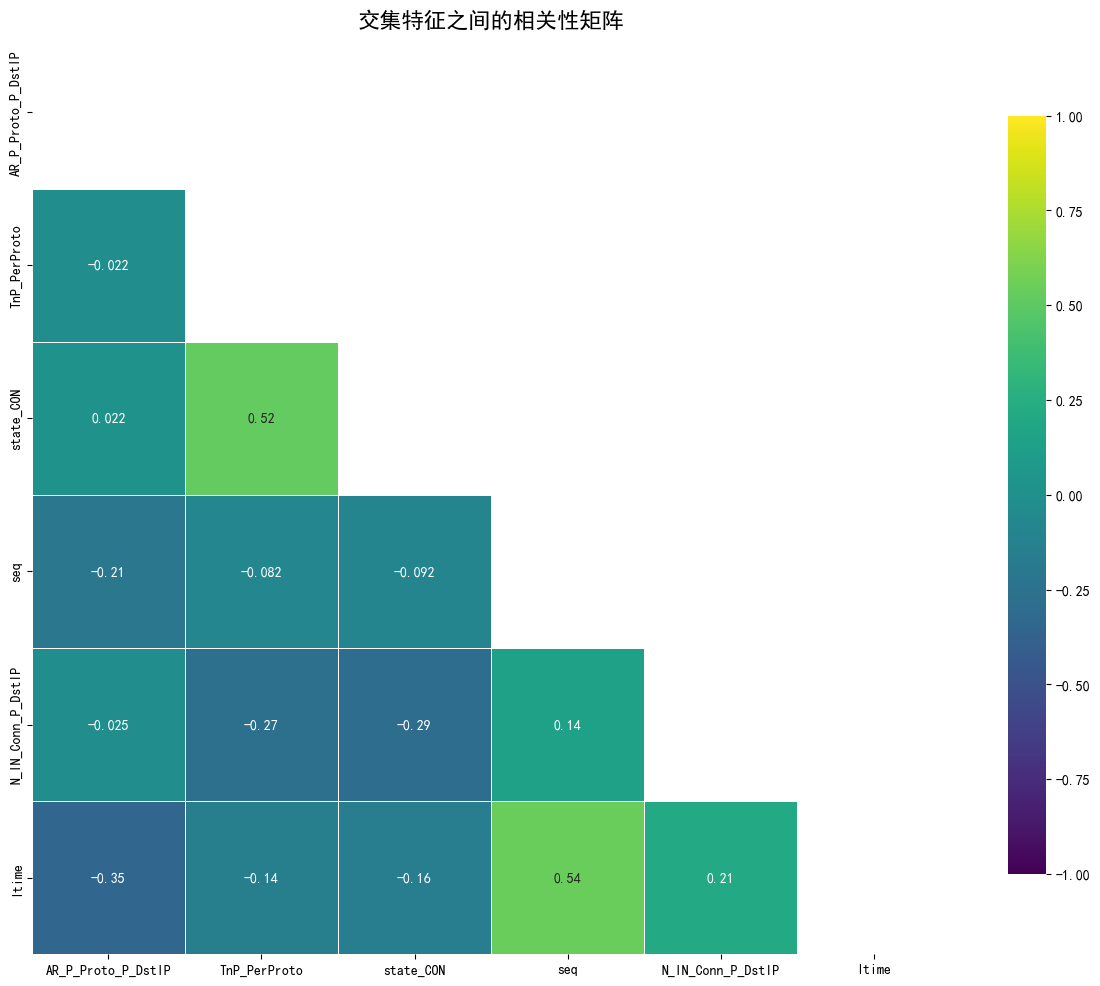

In [10]:

# 4.3 绘制交集特征的热力图
if len(common_features) > 0:
    plt.figure(figsize=(12, 10))
    common_corr = X[list(common_features)].corr()
    mask = np.triu(np.ones_like(common_corr, dtype=bool))

    sns.heatmap(common_corr, annot=True, cmap="viridis", linewidths=0.5,
                mask=mask, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})

    plt.title('交集特征之间的相关性矩阵', fontsize=16)
    plt.tight_layout()
    plt.show()



In [11]:
from sklearn.model_selection import train_test_split

# 使用交集特征作为最终特征集
x = X[list(common_features)]  # 选择交集特征（确保 common_features 是列表）

# 分割训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  # 80%训练，20%测试

# 打印数据集形状
print(f"Shape of training data: {x_train.shape}, {y_train.shape}")  # 打印训练集形状
print(f"Shape of testing data: {x_test.shape}, {y_test.shape}")     # 打印测试集形状


Shape of training data: (40427, 6), (40427,)
Shape of testing data: (10107, 6), (10107,)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# 使用LinearSVC替代SVC
svm = LinearSVC(C=1, max_iter=10000)
svm.fit(x_train, y_train)
svm_pred = svm.predict(x_test)
svm_conf = confusion_matrix(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred)
svm_acc = round(accuracy_score(y_test, svm_pred) * 100, ndigits=2)

print(f"Confusion Matrix : \n\n{svm_conf}")
print(f"\nClassification Report : \n\n{svm_report}")
print(f"\nThe Accuracy of Support Vector Machine is {svm_acc} %")

# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_conf = confusion_matrix(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)
lr_acc = round(accuracy_score(y_test, lr_pred) * 100,ndigits=2)
# 打印混淆矩阵
print(f"Confusion Matrix : \n\n{lr_conf}")

# 打印分类报告
print(f"\nClassification Report : \n\n{lr_report}")
# 解释：`lr_report` 是逻辑回归模型的分类报告。
# 分类报告包括每个类别的精确率（Precision）、召回率（Recall）、F1 分数（F1-Score）以及总体准确率（Accuracy）。
# 这些指标帮助评估模型在不同类别上的表现。

# 打印模型准确率
print(f"\nThe Accuracy of Logistic Regression is {lr_acc} %")

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 初始化高斯朴素贝叶斯模型
gnb = GaussianNB()

# 训练模型
gnb.fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)
gnb_conf = confusion_matrix(y_test, gnb_pred)
gnb_report = classification_report(y_test, gnb_pred)
gnb_acc = round(accuracy_score(y_test, gnb_pred) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{gnb_conf}")
print(f"\nClassification Report : \n\n{gnb_report}")
print(f"\nThe Accuracy of Gaussian Naive Bayes is {gnb_acc} %")

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 训练模型
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
bnb_pred = bnb.predict(x_test)
bnb_conf = confusion_matrix(y_test, bnb_pred)
bnb_report = classification_report(y_test, bnb_pred)
bnb_acc = round(accuracy_score(y_test, bnb_pred) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{bnb_conf}")
print(f"\nClassification Report : \n\n{bnb_report}")
print(f"\nThe Accuracy of Bernoulli Naive Bayes is {bnb_acc} %")





from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 训练模型
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_conf = confusion_matrix(y_test, knn_pred)
knn_report = classification_report(y_test, knn_pred)
knn_acc = round(accuracy_score(y_test, knn_pred) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{knn_conf}")
print(f"\nClassification Report : \n\n{knn_report}")
print(f"\nThe Accuracy of K Nearest Neighbors Classifier is {knn_acc} %")



from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 训练模型
# 定义模型
xgb = XGBClassifier(
    max_depth=1, 
    n_estimators=50, 
    learning_rate=0.3,
    subsample=0.5,
    colsample_bytree=0.5,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
xgb_conf = confusion_matrix(y_test, xgb_pred)
xgb_report = classification_report(y_test, xgb_pred)
xgb_acc = round(accuracy_score(y_test, xgb_pred) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{xgb_conf}")
print(f"\nClassification Report : \n\n{xgb_report}")
print(f"\nThe Accuracy of Extreme Gradient Boosting Classifier is {xgb_acc} %")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 训练模型
rfg = RandomForestClassifier(
    n_estimators=10, 
    max_depth=2, 
    min_samples_split=10, 
    random_state=42
)
rfg.fit(x_train, y_train)
rfg_pred = rfg.predict(x_test)
rfg_conf = confusion_matrix(y_test, rfg_pred)
rfg_report = classification_report(y_test, rfg_pred)
rfg_acc = round(accuracy_score(y_test, rfg_pred) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{rfg_conf}")
print(f"\nClassification Report : \n\n{rfg_report}")
print(f"\nThe Accuracy of Random Forest Classifier is {rfg_acc} %")

from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 数据标准化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# 定义正则化参数
regularization_parameter = 0.01

# 构建神经网络模型
neural_model = Sequential([
    tf.keras.layers.Dense(units=32, input_dim=x_train.shape[-1], activation="relu", 
                          kernel_regularizer=regularizers.l1(regularization_parameter)),
    tf.keras.layers.Dense(units=64, activation="relu", 
                          kernel_regularizer=regularizers.l1(regularization_parameter)),
    tf.keras.layers.Dense(units=128, activation="relu", 
                          kernel_regularizer=regularizers.l1(regularization_parameter)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation="relu", 
                          kernel_regularizer=regularizers.l1(regularization_parameter)),
    tf.keras.layers.Dense(units=5, activation="softmax")  # 修改为 5 个神经元，使用 softmax
])

# 打印模型结构
print(neural_model.summary())

# 自定义回调函数：当训练准确率达到 100% 时停止训练
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") == 1.0:
            print("\nAccuracy is 100%, so canceling training!")
            self.model.stop_training = True

callbacks = myCallback()

# 编译模型
neural_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss="sparse_categorical_crossentropy",  # 修改为多分类损失函数
                     metrics=["accuracy"])

# 训练模型
history = neural_model.fit(x_train, y_train,
                           epochs=50,
                           verbose=1,
                           batch_size=64,
                           validation_data=(x_test, y_test),
                           callbacks=[callbacks])

# 预测测试集
neural_pred = neural_model.predict(x_test)
neural_pred_classes = neural_pred.argmax(axis=1)  # 获取预测类别

# 计算混淆矩阵、分类报告和准确率
neural_conf = confusion_matrix(y_test, neural_pred_classes)
neural_report = classification_report(y_test, neural_pred_classes)
neural_acc = round(accuracy_score(y_test, neural_pred_classes) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{neural_conf}")
print(f"\nClassification Report : \n\n{neural_report}")
print(f"\nThe Accuracy of Neural Network Classifier is {neural_acc} %")


plt.show()


Confusion Matrix : 

[[ 959 2284    0  765    0]
 [ 974 2315    0  729    0]
 [   0    0    1   84    0]
 [   0    0    0 1984    0]
 [   0    0    0   12    0]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.50      0.24      0.32      4008
           1       0.50      0.58      0.54      4018
           2       1.00      0.01      0.02        85
           3       0.56      1.00      0.71      1984
           4       0.00      0.00      0.00        12

    accuracy                           0.52     10107
   macro avg       0.51      0.37      0.32     10107
weighted avg       0.51      0.52      0.48     10107


The Accuracy of Support Vector Machine is 52.03 %
Confusion Matrix : 

[[1670 1886    0  452    0]
 [1641 1954    0  423    0]
 [   6    0    0   79    0]
 [ 247    0    0 1737    0]
 [   0    0    0   12    0]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.47    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,805 (50.02 KB)

 Trainable params: 12,805 (50.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5473 - loss: 5.3360 - val_accuracy: 0.7751 - val_loss: 0.8540
Epoch 2/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6214 - loss: 0.8573 - val_accuracy: 0.7596 - val_loss: 0.7531
Epoch 3/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7616 - loss: 0.7421 - val_accuracy: 0.7698 - val_loss: 0.6262
Epoch 4/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8331 - loss: 0.6396 - val_accuracy: 0.9901 - val_loss: 0.5069
Epoch 5/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9433 - loss: 0.5124 - val_accuracy: 0.9903 - val_loss: 0.4112
Epoch 6/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9689 - loss: 0.4382 - val_accuracy: 0.9903 - val_loss: 0.3762
Epoch 7/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9748 - loss: 0.4235 - val_accuracy: 0.9903 - val_loss: 0.3836
Epoch 8/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9752 - loss: 0.4187 - val_accurac

In [13]:
from tabpfn_extensions import TabPFNClassifier
from tabpfn_extensions.rf_pfn import RandomForestTabPFNClassifier


tabpfn_subsample_clf = TabPFNClassifier(
    ignore_pretraining_limits=True,  # (bool) Allows the use of datasets larger than pretraining limits.
    n_estimators=32,  # (int) Number of estimators for ensembling; improves accuracy with higher values.
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000,  # (int) Maximum number of samples per inference step to manage memory usage.
    },
)

# Train the model on the training set
tabpfn_subsample_clf.fit(x_train, y_train)

# Predict probabilities and class labels on the test set
prediction_probabilities = tabpfn_subsample_clf.predict_proba(x_test)
predictions = np.argmax(prediction_probabilities, axis=1)

# Evaluate performance metrics
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)
accuracy = round(accuracy_score(y_test, predictions) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{conf_matrix}")
print(f"\nClassification Report : \n\n{class_report}")
print(f"\nThe Accuracy of TabPFN Subsampled Ensemble Classifier is {accuracy} %")
# ----------------------------
# Classification - Strategy 2: Tree-based Model with Node Subsampling
# ----------------------------
print("\n--- Classification: Strategy 2 (Tree-based Model) ---")
clf_base = TabPFNClassifier(
    ignore_pretraining_limits=True,  # (bool) Allows training on larger datasets.
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000,  # (int) Number of samples to subsample for inference at each node.
    },
)

# Use a tree-based ensemble model with TabPFN as the base estimator
tabpfn_tree_clf = RandomForestTabPFNClassifier(
    tabpfn=clf_base,  # (TabPFNClassifier) Base TabPFN model to be used within the Random Forest structure.
    verbose=1,  # (int) Controls the verbosity; higher values show more details.
    max_predict_time=60,  # (int) Maximum prediction time allowed in seconds.
)

# Train the tree-based model on the training set
tabpfn_tree_clf.fit(x_train, y_train)

# Evaluate performance metrics
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)
accuracy = round(accuracy_score(y_test, predictions) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{conf_matrix}")
print(f"\nClassification Report : \n\n{class_report}")
print(f"\nThe Accuracy of TabPFN Tree-based Classifier is {accuracy} %")

Confusion Matrix : 

[[4008    0    0    0    0]
 [   0 4018    0    0    0]
 [   0    0   85    0    0]
 [   0    0    2 1982    0]
 [   0    0    0    0   12]]

Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4008
           1       1.00      1.00      1.00      4018
           2       0.98      1.00      0.99        85
           3       1.00      1.00      1.00      1984
           4       1.00      1.00      1.00        12

    accuracy                           1.00     10107
   macro avg       1.00      1.00      1.00     10107
weighted avg       1.00      1.00      1.00     10107


The Accuracy of TabPFN Subsampled Ensemble Classifier is 99.98 %

--- Classification: Strategy 2 (Tree-based Model) ---
Confusion Matrix : 

[[4008    0    0    0    0]
 [   0 4018    0    0    0]
 [   0    0   85    0    0]
 [   0    0    2 1982    0]
 [   0    0    0    0   12]]

Classification Report : 

            

Confusion Matrix : 

[[4008    0    0    0    0]
 [   0 4018    0    0    0]
 [   0    0   84    1    0]
 [   0    0    2 1982    0]
 [   0    0    0    0   12]]

Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4008
           1       1.00      1.00      1.00      4018
           2       0.98      0.99      0.98        85
           3       1.00      1.00      1.00      1984
           4       1.00      1.00      1.00        12

    accuracy                           1.00     10107
   macro avg       1.00      1.00      1.00     10107
weighted avg       1.00      1.00      1.00     10107


The Accuracy of TabPFN Tree-based Classifier is 99.97 %


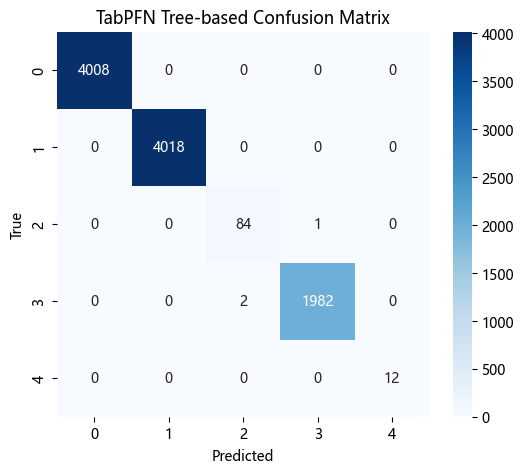

In [24]:
# 可视化混淆矩阵的函数
def plot_confusion_matrix(y_true, y_pred, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')  # 保存为 PDF 格式
    plt.show()

# Predict probabilities and class labels on the test set
prediction_probabilities_tree = tabpfn_tree_clf.predict_proba(x_test)
predictions_tree = np.argmax(prediction_probabilities_tree, axis=1)

# Evaluate performance metrics
conf_matrix_tree = confusion_matrix(y_test, predictions_tree)
class_report_tree = classification_report(y_test, predictions_tree)
accuracy_tree = round(accuracy_score(y_test, predictions_tree) * 100, ndigits=2)

# 输出结果
print(f"Confusion Matrix : \n\n{conf_matrix_tree}")
print(f"\nClassification Report : \n\n{class_report_tree}")
print(f"\nThe Accuracy of TabPFN Tree-based Classifier is {accuracy_tree} %")

# 绘制并保存混淆矩阵图
plot_confusion_matrix(y_test, predictions_tree,
                      title="TabPFN Tree-based Confusion Matrix",
                      save_path="TabPFN_Tree_based_Confusion_Matrix.pdf")

AUC Scores:
Logistic Regression: Micro-AUC = 0.693
Gaussian NB: Micro-AUC = 0.498
Bernoulli NB: Micro-AUC = 0.275
SVM: Micro-AUC = 0.699
Random Forest: Micro-AUC = 0.598
KNN: Micro-AUC = 0.354
XGBoost: Micro-AUC = 0.391
TABPFN: Micro-AUC = 1.000


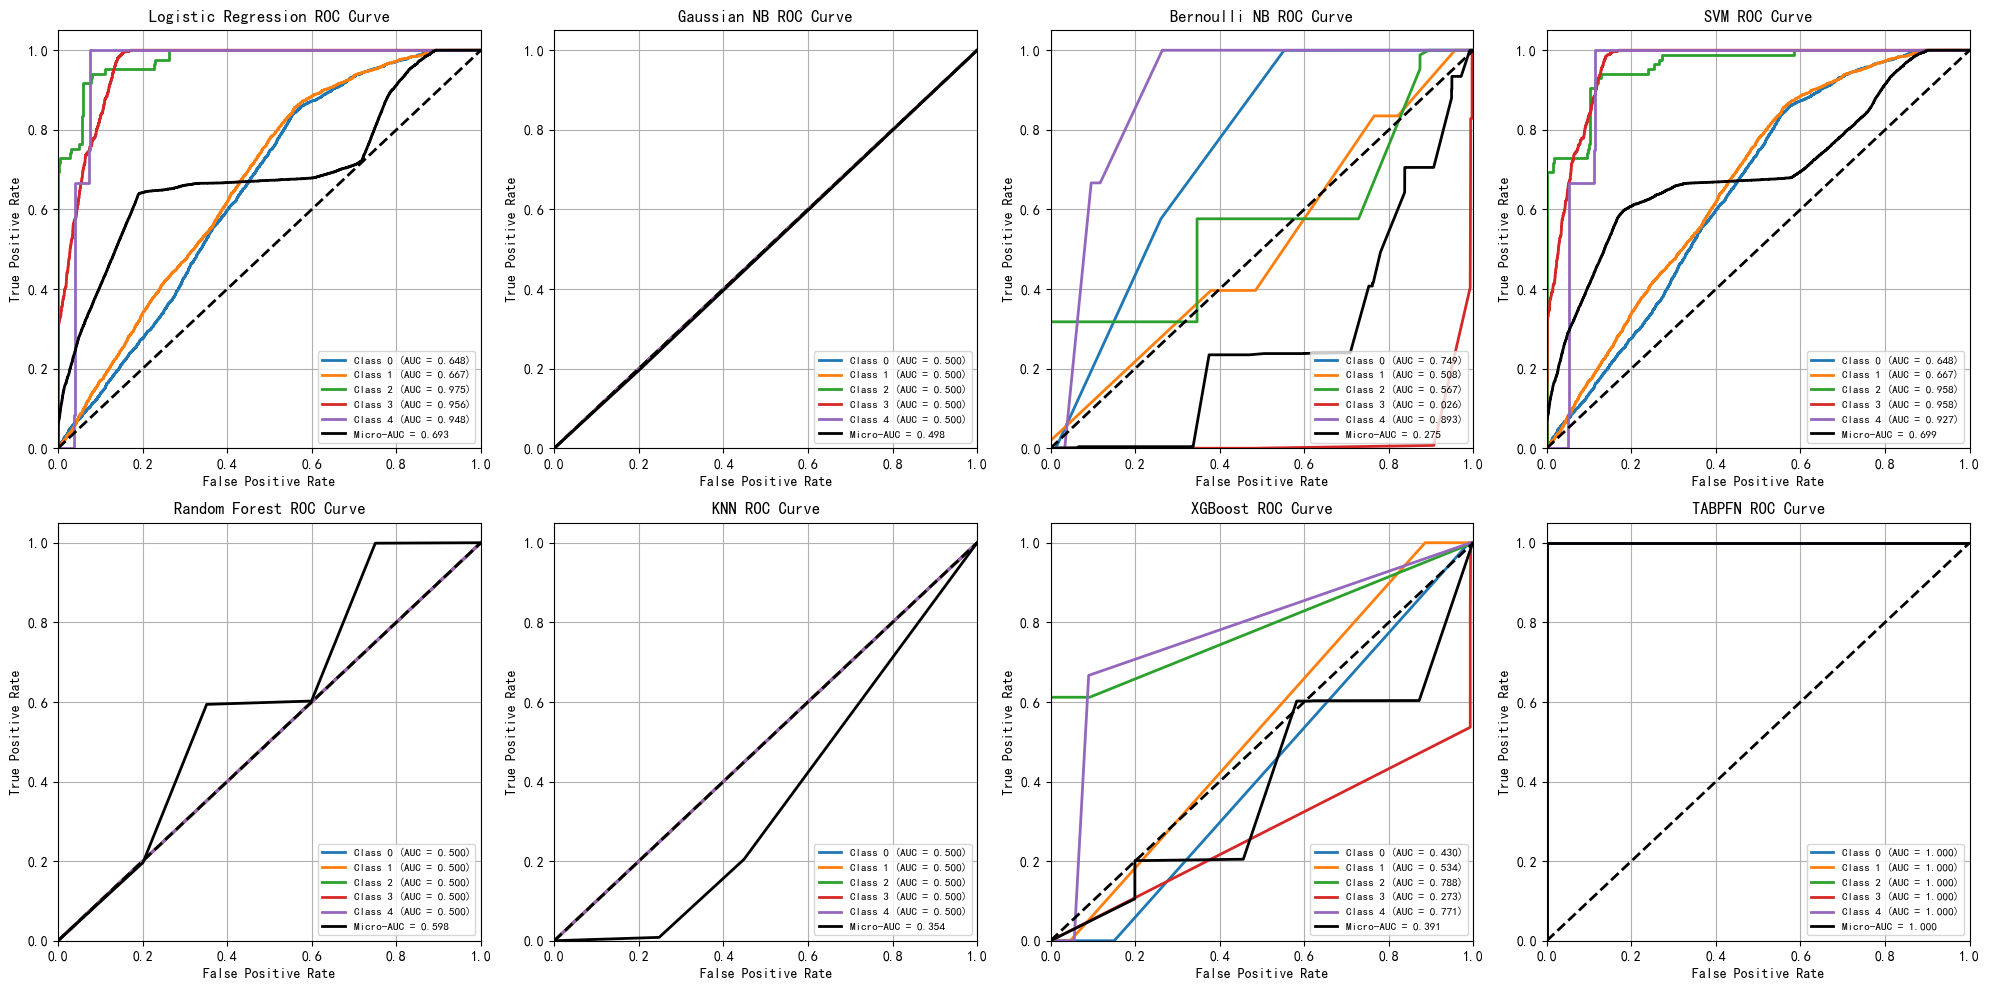

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# 假设 all_models 是一个包含模型的字典，colors 是一个颜色列表
all_models = {
    'Logistic Regression': lr,
    'Gaussian NB': gnb,  # 高斯朴素贝叶斯模型
    'Bernoulli NB': bnb,  # 伯努利朴素贝叶斯模型
    'SVM': svm,  # 支持向量机模型
    'Random Forest': rfg,  # 随机森林模型
    'KNN': knn,  # K近邻模型
    'XGBoost': xgb,  # XGBoost模型
    'TABPFN': tabpfn_tree_clf  # TABPFN模型    
}

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'cyan']

# 将 y_test 进行二值化
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# 创建一个大图，包含 8 个子图
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# 打印 AUC 数值
print("AUC Scores:")
for idx, ((name, model), color) in enumerate(zip(all_models.items(), colors)):
    if hasattr(model, 'predict_proba'):  # 如果模型有predict_proba方法
        y_pred_prob = model.predict_proba(x_test)
    elif hasattr(model, 'decision_function'):  # 如果模型有decision_function方法
        y_pred_prob = model.decision_function(x_test)
        if len(y_pred_prob.shape) == 1:
            y_pred_prob = np.vstack([-y_pred_prob, y_pred_prob]).T
        y_pred_prob = (y_pred_prob - y_pred_prob.min()) / (y_pred_prob.max() - y_pred_prob.min())  # 归一化到[0,1]区间
    else:
        print(f"{name} does not support probability or decision function.")
        continue  # 如果模型既没有predict_proba也没有decision_function，则跳过

    # 为每个类别计算 ROC 曲线和 AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 计算微平均 ROC 曲线和 AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # 打印 AUC 数值
    print(f"{name}: Micro-AUC = {roc_auc['micro']:.3f}")

    # 绘制每个类别的 ROC 曲线和微平均 ROC 曲线
    for i in range(n_classes):
        axes[idx].plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.3f})')
    axes[idx].plot(fpr["micro"], tpr["micro"], lw=2, color='black', label=f'Micro-AUC = {roc_auc["micro"]:.3f}')

    # 绘制对角线（随机猜测的基线）
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{name} ROC Curve')
    axes[idx].legend(loc='lower right', fontsize=8)
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig('不同模型多分类ROC曲线合集.pdf', format='pdf')
plt.show()
    

AUC Scores:
Logistic Regression: Mean AUC = 0.839
Gaussian NB: Mean AUC = 0.500
Bernoulli NB: Mean AUC = 0.549
SVM: Mean AUC = 0.832
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
neural: Mean AUC = 0.904
KNN: Mean AUC = 0.500
XGBoost: Mean AUC = 0.559
TABPFN: Mean AUC = 1.000


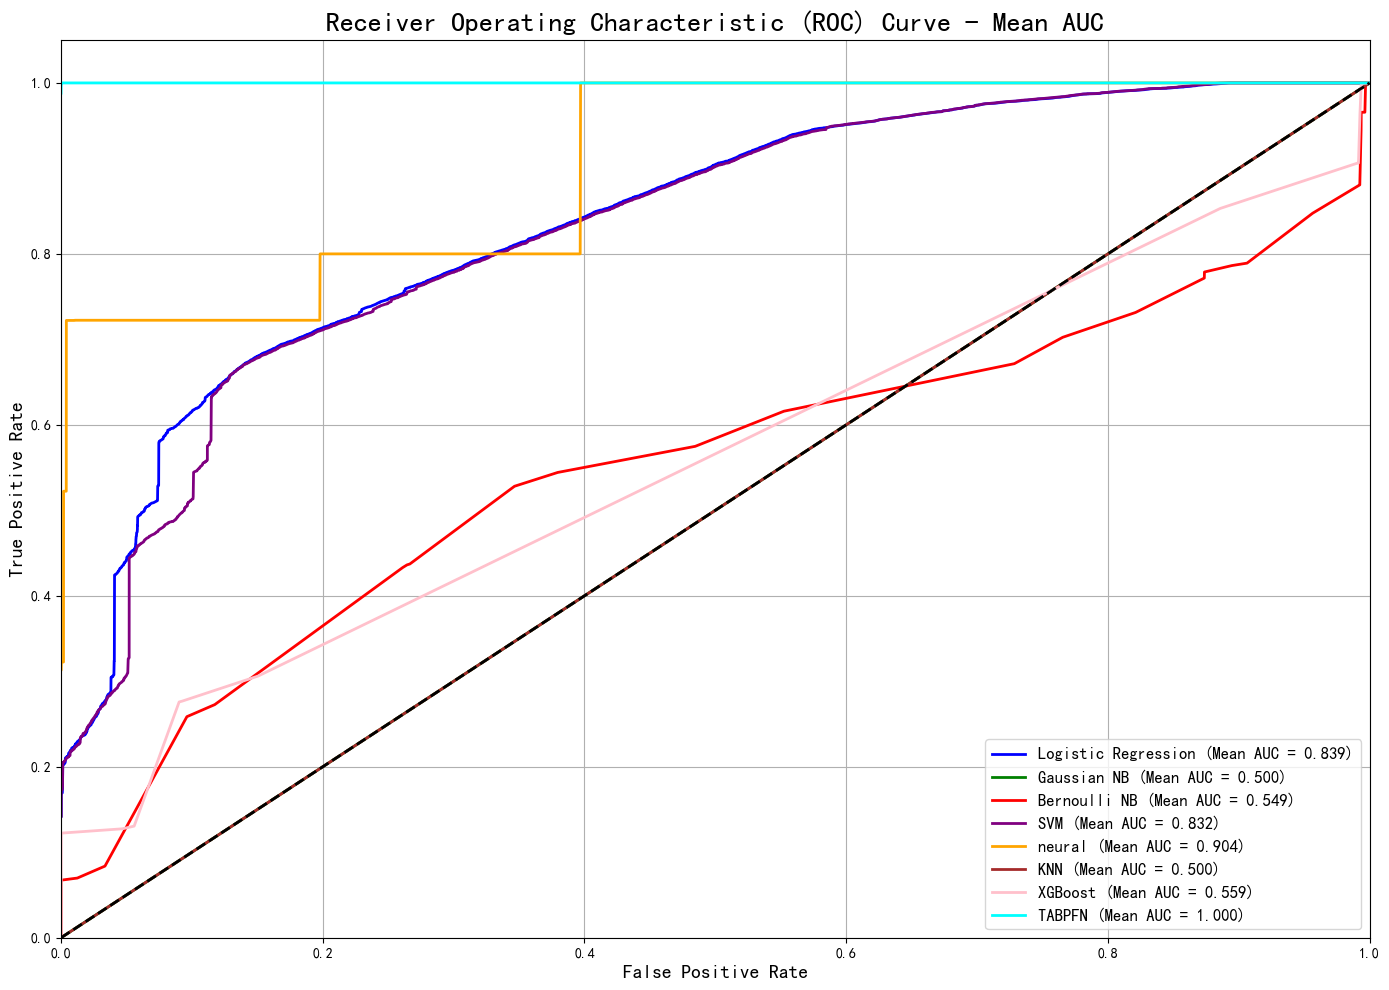

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# 假设 all_models 是一个包含模型的字典，colors 是一个颜色列表
all_models = {
    'Logistic Regression': lr,
    'Gaussian NB': gnb,  # 高斯朴素贝叶斯模型
    'Bernoulli NB': bnb,  # 伯努利朴素贝叶斯模型
    'SVM': svm,  # 支持向量机模型
    'neural': neural_model,  # 随机森林模型
    'KNN': knn,  # K近邻模型
    'XGBoost': xgb,  # XGBoost模型
    'TABPFN': tabpfn_tree_clf  # TABPFN模型    
}

# 假设 y_test 是多分类标签，这里对其进行二值化处理
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'cyan']

plt.figure(figsize=(14, 10))  # 创建一个14x10英寸的图形

# 打印 AUC 数值
print("AUC Scores:")
for (name, model), color in zip(all_models.items(), colors):
    try:
        if name == 'neural':
            y_score = model.predict(x_test)
        elif name == 'SVM':
            y_score = model.decision_function(x_test)
            if len(y_score.shape) == 1:
                y_score = np.vstack([-y_score, y_score]).T
        else:
            y_score = model.predict_proba(x_test)

        # 计算每个类别的ROC曲线和AUC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 计算均值AUC
        mean_roc_auc = np.mean(list(roc_auc.values()))
        print(f"{name}: Mean AUC = {mean_roc_auc:.3f}")

        # 计算均值FPR和TPR
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        # 绘制均值ROC曲线
        plt.plot(all_fpr, mean_tpr, lw=2, color=color,
                 label=f'{name} (Mean AUC = {mean_roc_auc:.3f})')
    except Exception as e:
        print(f"Error occurred while processing {name}: {e}")

# 绘制对角线（随机猜测的基线）
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围
plt.xlabel('False Positive Rate', fontsize=14)  # 设置x轴标签
plt.ylabel('True Positive Rate', fontsize=14)  # 设置y轴标签
plt.title('Receiver Operating Characteristic (ROC) Curve - Mean AUC', fontsize=20)  # 设置图表标题
plt.legend(loc='lower right', fontsize=12)  # 添加图例
plt.grid(True)  # 显示网格
plt.tight_layout()  # 自动调整子图参数
plt.savefig('不同模型ROC曲线_均值AUC.pdf', format='pdf')  # 保存为 PDF 格式
plt.show()  # 显示图形    

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


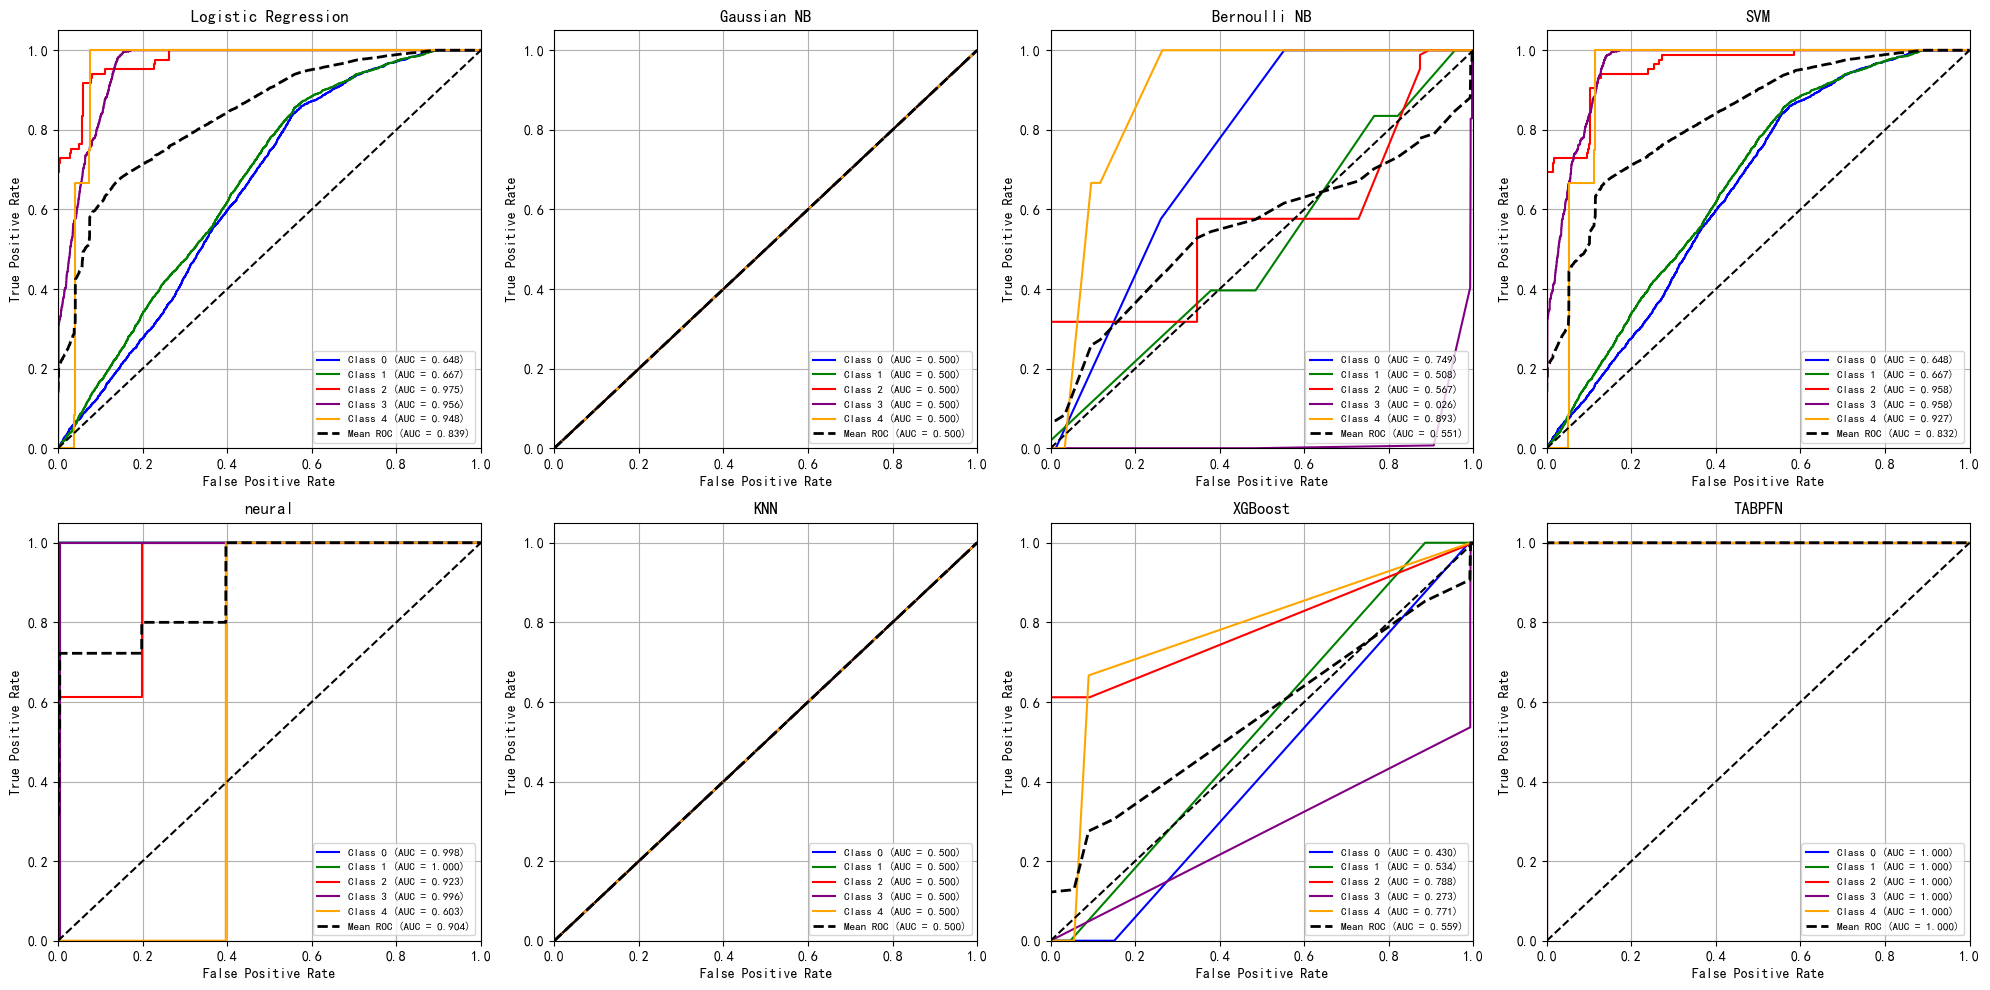

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# 假设 all_models 是一个包含模型的字典，colors 是一个颜色列表
all_models = {
    'Logistic Regression': lr,
    'Gaussian NB': gnb,  # 高斯朴素贝叶斯模型
    'Bernoulli NB': bnb,  # 伯努利朴素贝叶斯模型
    'SVM': svm,  # 支持向量机模型
    'neural': neural_model,  # 神经网络模型
    'KNN': knn,  # K近邻模型
    'XGBoost': xgb,  # XGBoost模型
    'TABPFN': tabpfn_tree_clf  # TABPFN模型    
}

# 假设 y_test 是多分类标签，这里对其进行二值化处理
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# 设置颜色列表（每类一条颜色）
class_colors = ['blue', 'green', 'red', 'purple', 'orange']
mean_color = 'black'

# 创建一个 2x4 的子图布局
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 总共8个子图
axes = axes.flatten()  # 展平成一维数组方便遍历

for idx, (name, model) in enumerate(all_models.items()):
    ax = axes[idx]
    try:
        if name == 'neural':
            y_score = model.predict(x_test)
        elif name == 'SVM':
            y_score = model.decision_function(x_test)
            if len(y_score.shape) == 1:
                y_score = np.vstack([-y_score, y_score]).T
        else:
            y_score = model.predict_proba(x_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 计算平均 AUC 和平均 TPR/FPR
        mean_roc_auc = np.mean(list(roc_auc.values()))
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        mean_auc = auc(all_fpr, mean_tpr)

        # 绘制每个类别的 ROC 曲线
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], lw=1.5, color=class_colors[i],
                    label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

        # 绘制平均 ROC 曲线
        ax.plot(all_fpr, mean_tpr, lw=2, color=mean_color, linestyle='--',
                label=f'Mean ROC (AUC = {mean_auc:.3f})')

        # 设置子图标题和样式
        ax.set_title(f"{name}", fontsize=12)
        ax.plot([0, 1], [0, 1], 'k--', lw=1.5)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True)

    except Exception as e:
        print(f"Error occurred while processing {name}: {e}")
        ax.set_title(f"{name} - Error", fontsize=12)
        ax.text(0.5, 0.5, 'Error', ha='center', va='center', fontsize=12, color='red')

# 自动调整布局
plt.tight_layout()
plt.show()

AUC Scores:
Logistic Regression: Mean AUC = 0.839
Gaussian NB: Mean AUC = 0.500
Bernoulli NB: Mean AUC = 0.549
SVM: Mean AUC = 0.832
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
neural: Mean AUC = 0.904
KNN: Mean AUC = 0.500
XGBoost: Mean AUC = 0.559
TABPFN: Mean AUC = 1.000


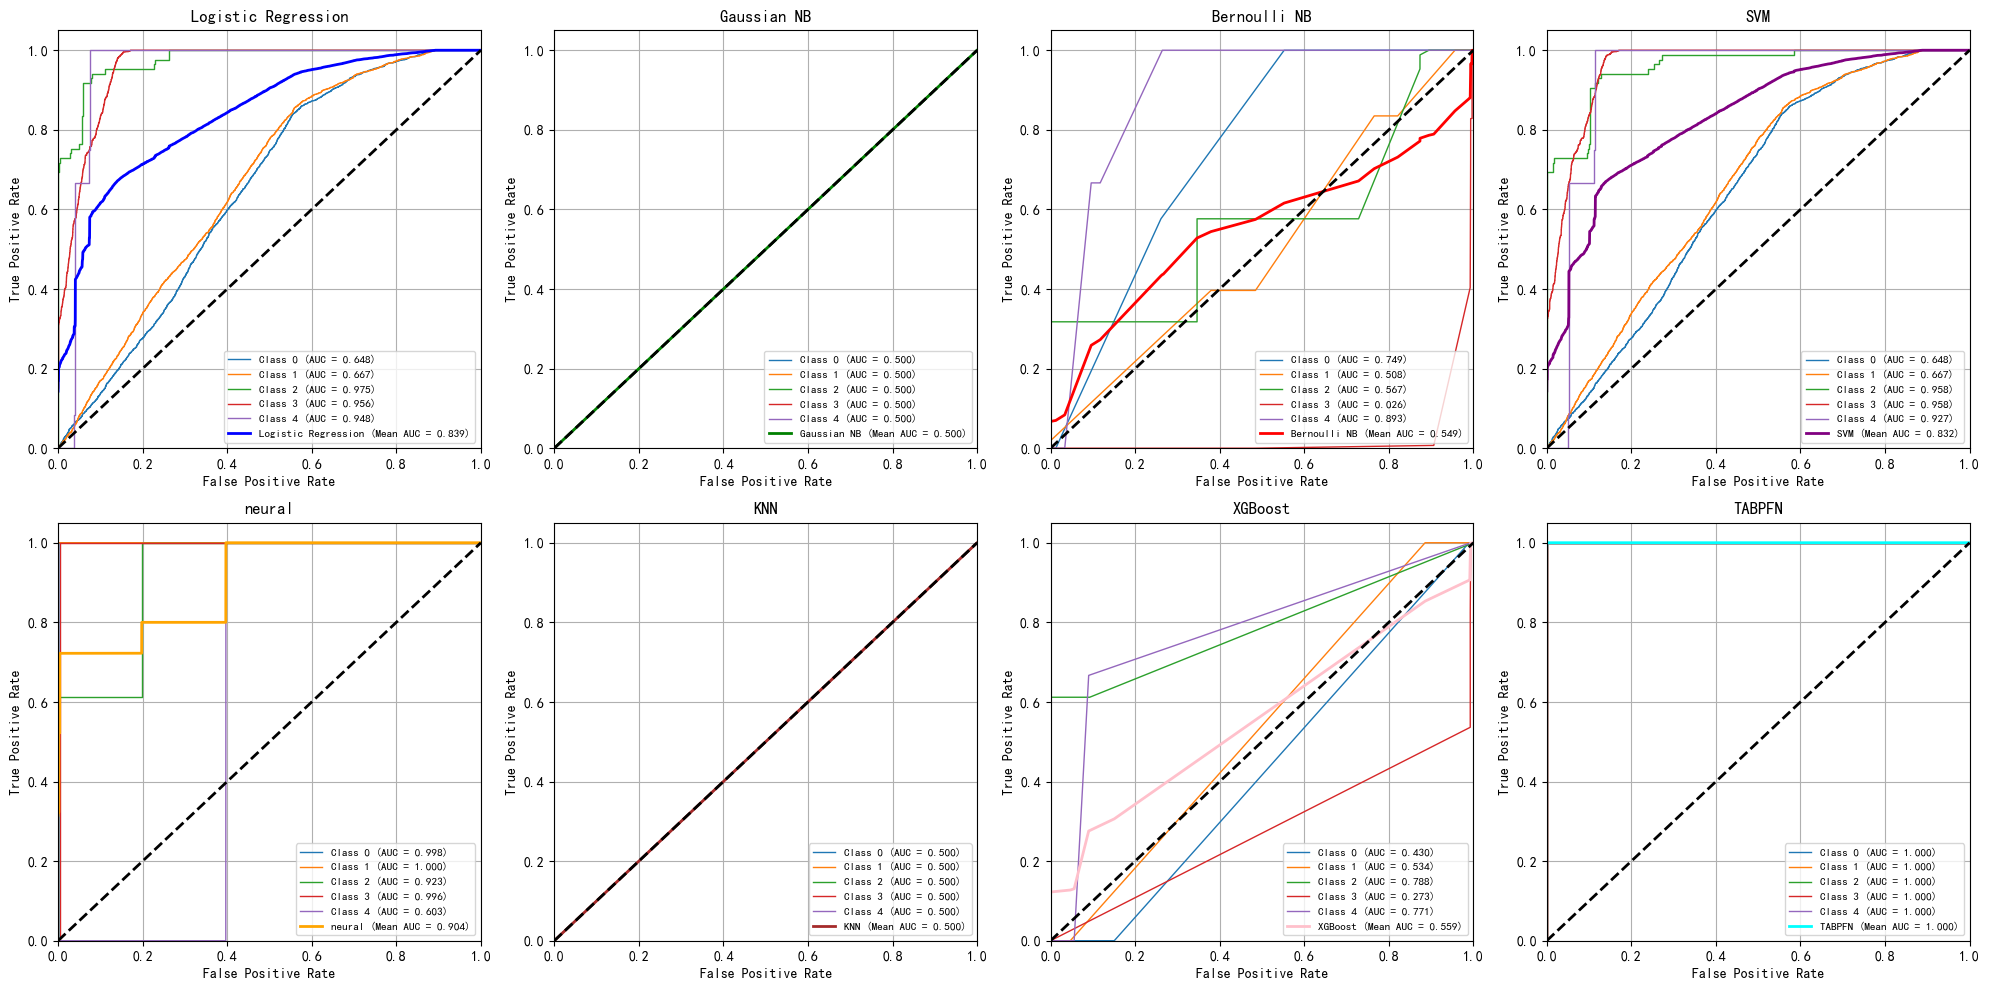

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# 假设 all_models 是一个包含模型的字典，colors 是一个颜色列表
all_models = {
    'Logistic Regression': lr,
    'Gaussian NB': gnb,  # 高斯朴素贝叶斯模型
    'Bernoulli NB': bnb,  # 伯努利朴素贝叶斯模型
    'SVM': svm,  # 支持向量机模型
    'neural': neural_model,  # 随机森林模型
    'KNN': knn,  # K近邻模型
    'XGBoost': xgb,  # XGBoost模型
    'TABPFN': tabpfn_tree_clf  # TABPFN模型    
}

# 假设 y_test 是多分类标签，这里对其进行二值化处理
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'cyan']

# 创建一个 2 行 4 列的子图布局
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# 打印 AUC 数值
print("AUC Scores:")
for i, ((name, model), color) in enumerate(zip(all_models.items(), colors)):
    try:
        if name == 'neural':
            y_score = model.predict(x_test)
        elif name == 'SVM':
            y_score = model.decision_function(x_test)
            if len(y_score.shape) == 1:
                y_score = np.vstack([-y_score, y_score]).T
        else:
            y_score = model.predict_proba(x_test)

        # 计算每个类别的ROC曲线和AUC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(n_classes):
            fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # 计算均值AUC
        mean_roc_auc = np.mean(list(roc_auc.values()))
        print(f"{name}: Mean AUC = {mean_roc_auc:.3f}")

        # 计算均值FPR和TPR
        all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for j in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
        mean_tpr /= n_classes

        # 在子图中绘制每个类别的 ROC 曲线
        for j in range(n_classes):
            axes[i].plot(fpr[j], tpr[j], lw=1, label=f'Class {j} (AUC = {roc_auc[j]:.3f})')

        # 绘制均值ROC曲线
        axes[i].plot(all_fpr, mean_tpr, lw=2, color=color,
                     label=f'{name} (Mean AUC = {mean_roc_auc:.3f})')

        # 绘制对角线（随机猜测的基线）
        axes[i].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(name)
        axes[i].legend(loc='lower right', fontsize=8)
        axes[i].grid(True)

    except Exception as e:
        print(f"Error occurred while processing {name}: {e}")

plt.tight_layout()
plt.savefig('不同模型ROC曲线_均值AUC_子图.pdf', format='pdf')
plt.show()

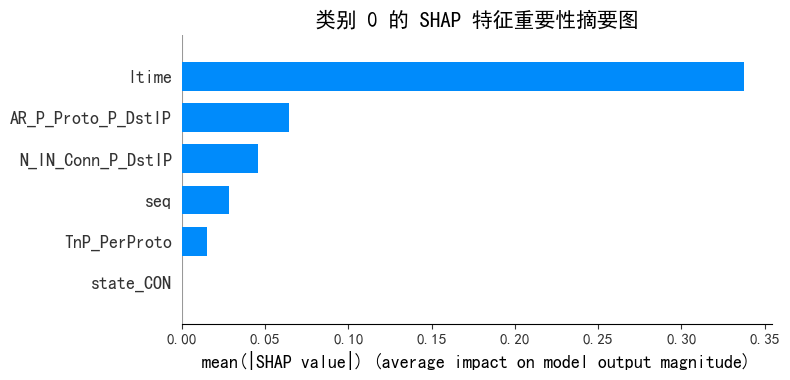

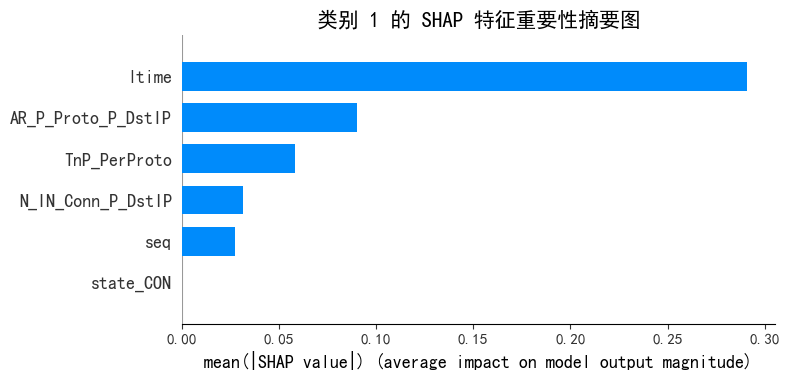

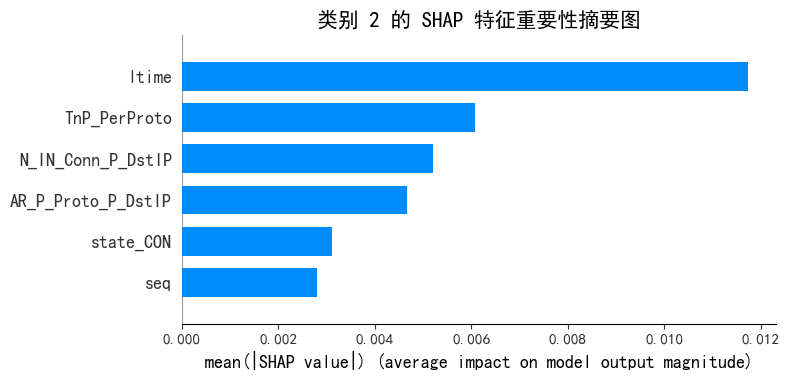

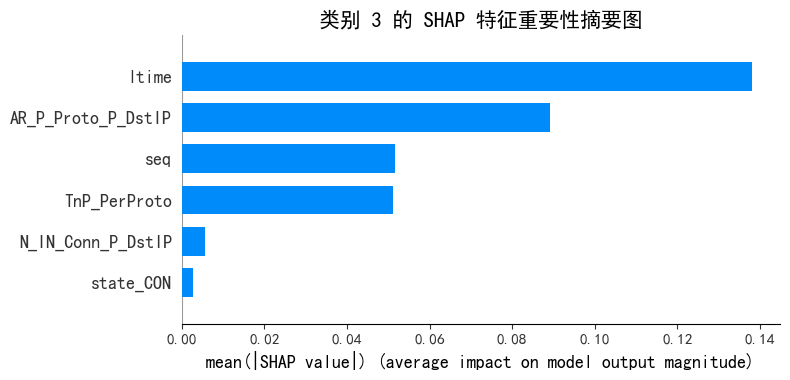

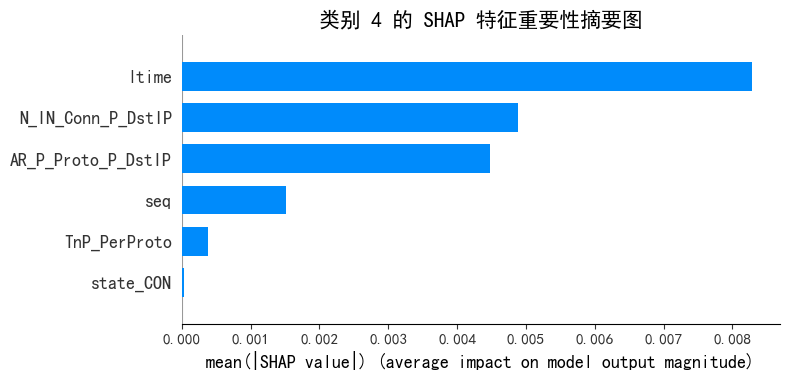

In [18]:
import shap

x_train=pd.DataFrame(x_train)#把数据转化为DataFrame

explainer = shap.TreeExplainer(tabpfn_tree_clf)
shap_values = explainer(x_train)
for i in range(shap_values.shape[2]): # 假设 shap_values 是一个三维数组，第三维对应于类别
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values[:,:,i], x_train, feature_names=x.columns, plot_type="bar", show=False)
    plt.title(f"类别 {i} 的 SHAP 特征重要性摘要图", fontsize=15)
    plt.tight_layout()
    plt.show()


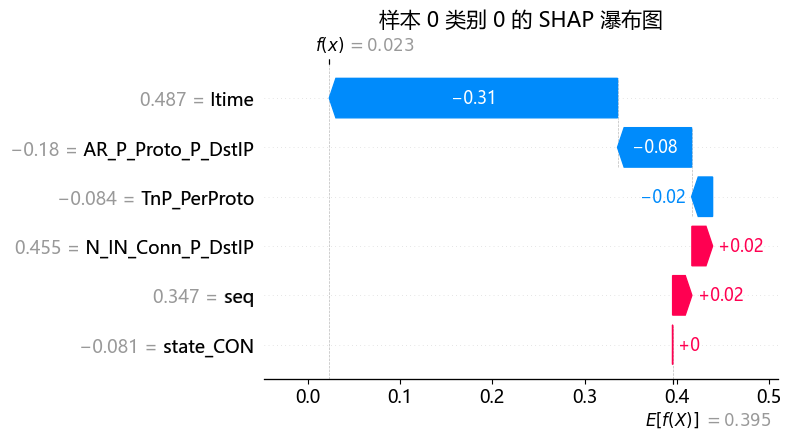

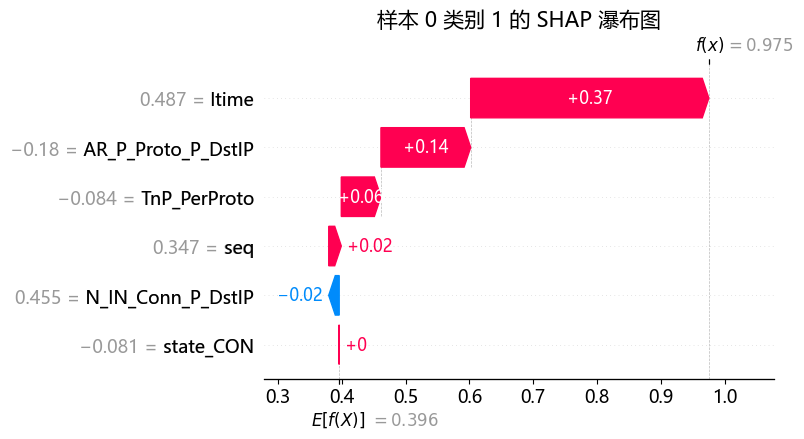

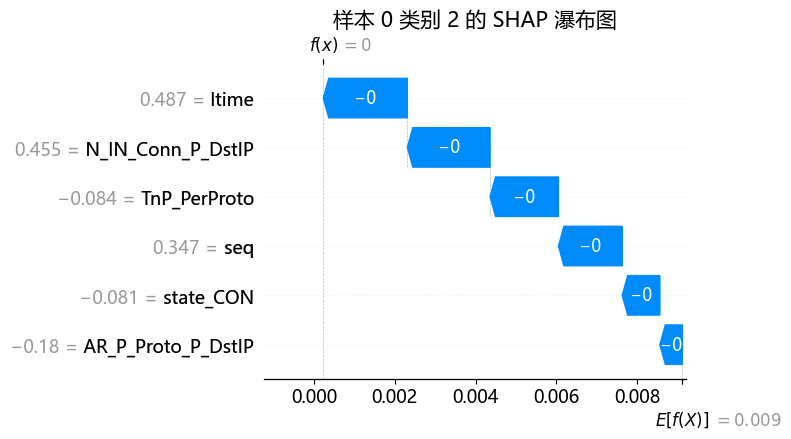

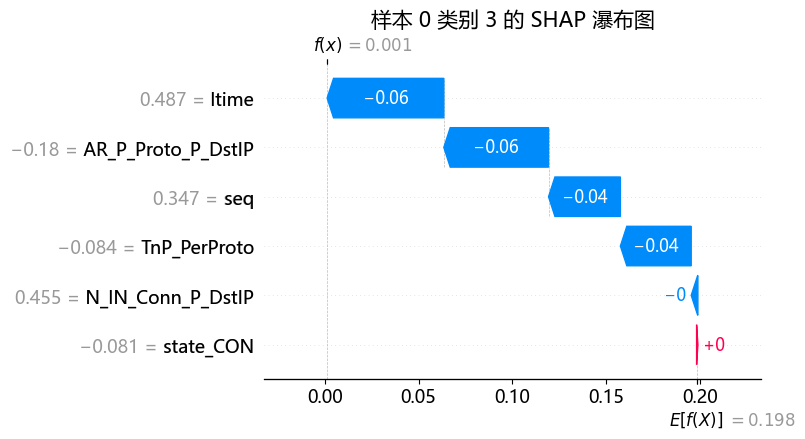

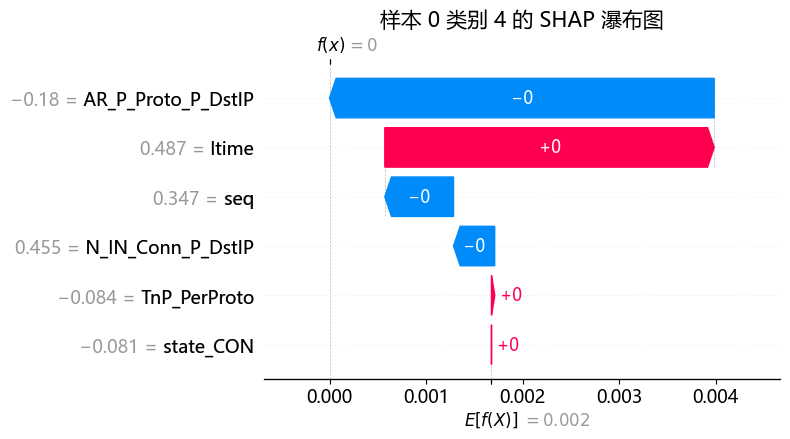

In [19]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 设置字体，确保正负号能正确显示
# 设置兼容中英文的字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

for i in range(shap_values.shape[2]):  # 假设 shap_values 是一个三维数组，第三维对应于类别
    for j in range(1):
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(shap.Explanation(values=shap_values[j][:, i].values,
                                             base_values=shap_values.base_values[j][i],
                                             data=x_train.iloc[j],
                                             feature_names=x.columns),
                            show=False)
        plt.title(f"样本 {j} 类别 {i} 的 SHAP 瀑布图", fontsize=15)
        plt.tight_layout()
        plt.show()

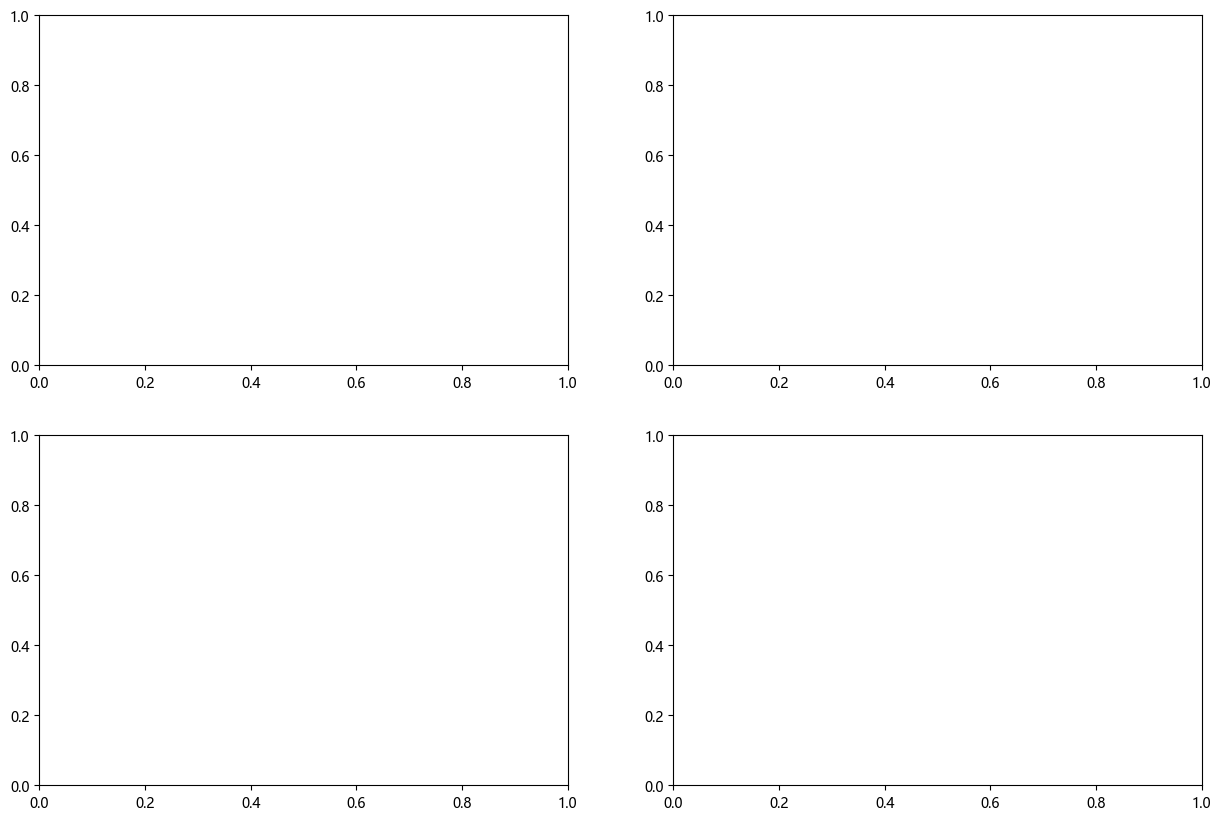

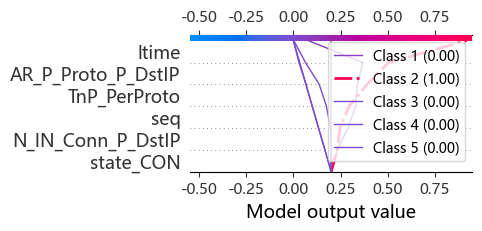

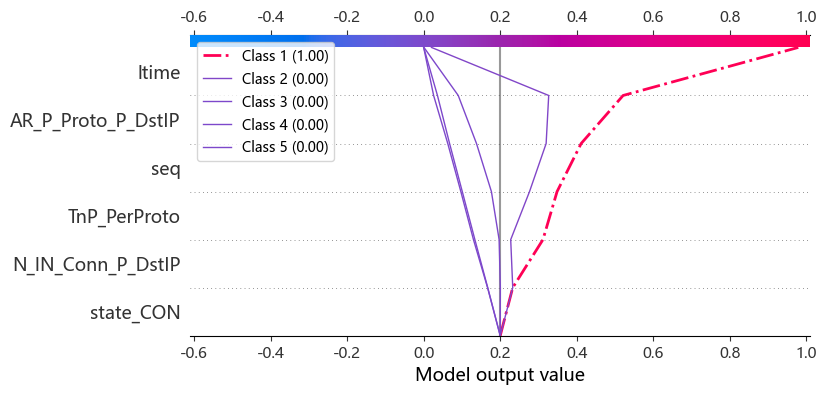

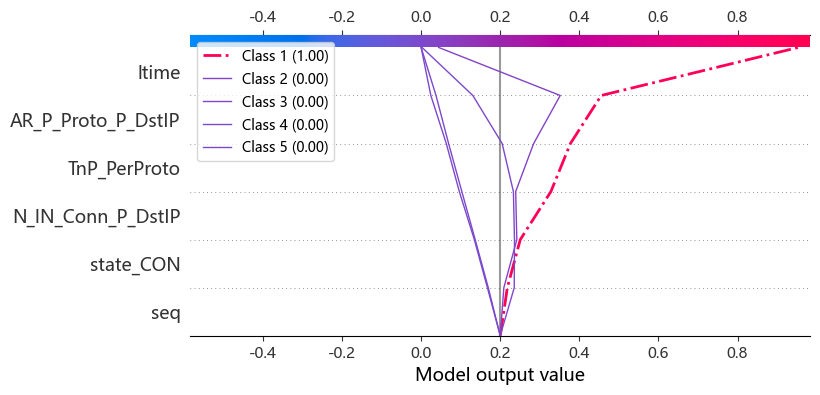

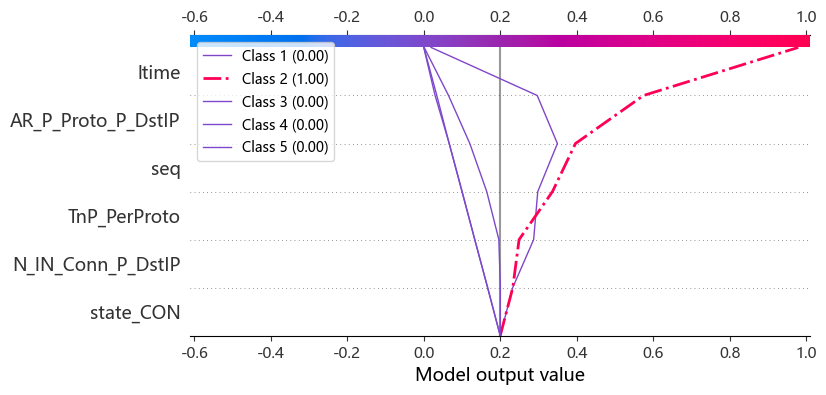

In [27]:
import shap

# 假设x_test, y_test, explainer, model已经定义并初始化
# 仅取前20个样本
X, y = x_test[:20], y_test[:20]

sh_raw = explainer.shap_values(X)  # shape likely: (n_samples, n_features, n_classes)
ev_raw = explainer.expected_value  # shape likely: (n_classes,)
# ✅ 手动转换为列表格式
if isinstance(sh_raw, np.ndarray) and sh_raw.ndim == 3:
    sh = [sh_raw[:, :, i] for i in range(sh_raw.shape[2])]
else:
    sh = sh_raw

if not isinstance(ev_raw, list):
    ev = list(ev_raw)
else:
    ev = ev_raw
# ✅ 确保 sh 和 ev 是列表（这是关键）
assert isinstance(sh, list) and len(sh) == 5
assert isinstance(ev, list) and len(ev) == 5
# 对这些样本进行预测
p = tabpfn_tree_clf.predict_proba(X)  # 注意这里可能需要使用predict_proba来获取类别概率而不是直接的类别标签

# 可视化若干样本
for i in [0, 1, 2,3]:  # 选择一些样本
    labels = [f'Class {j + 1} ({p[i, j]:0.2f})' for j in range(5)]
    shap.multioutput_decision_plot(ev, sh, i, features=X, highlight=np.argmax(p[i]), legend_labels=labels,feature_names=x.columns.tolist())

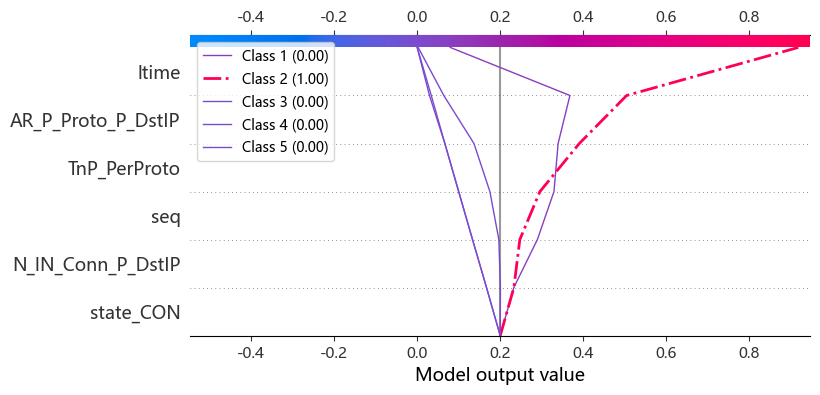

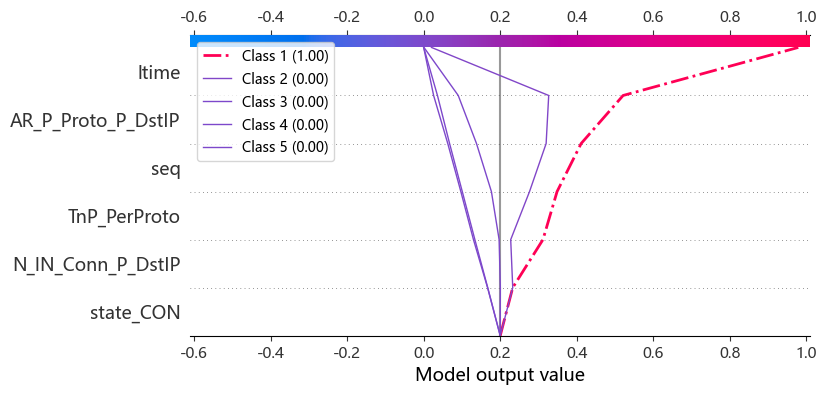

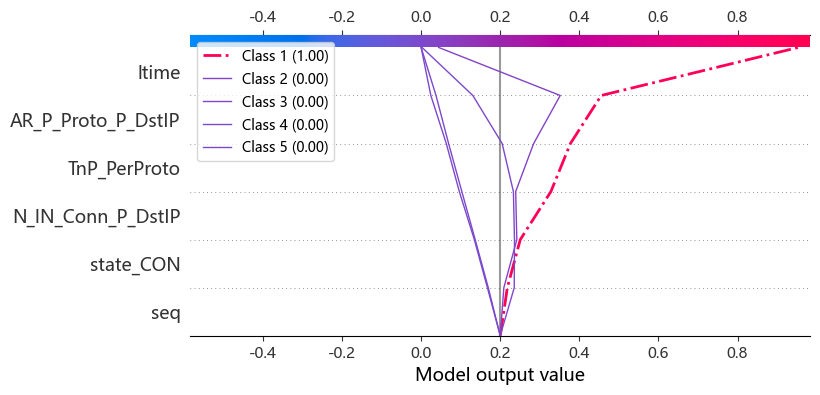

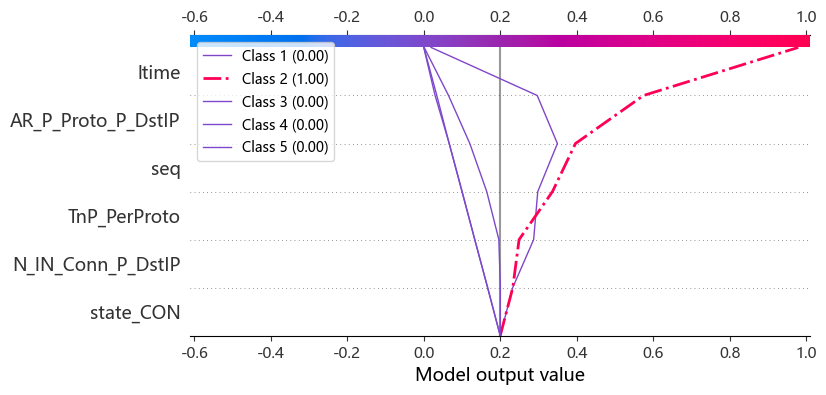

✅ 四张 SHAP 决策图已成功拼接并保存为 'combined_shap_plots.png'


In [34]:
import os
import matplotlib.pyplot as plt
import shap

# 创建临时目录保存图片
os.makedirs("temp_shap_images", exist_ok=True)

sample_indices = [0, 1, 2, 3]  # 要可视化的样本索引

for idx, i in enumerate(sample_indices):
    labels = [f'Class {j + 1} ({p[i, j]:0.2f})' for j in range(5)]
    
    # 绘制单个决策图
    shap.multioutput_decision_plot(ev, sh, i, features=X[i], highlight=np.argmax(p[i]),
                                   legend_labels=labels, feature_names=x.columns.tolist(),
                                   show=True)
    
    # 设置标题
    plt.title(f"Sample {i}", fontsize=14)
    
    # 保存图像
    plt.savefig(f"temp_shap_images/sample_{i}.png", bbox_inches='tight', dpi=200)
    plt.close()
    from PIL import Image

# 加载图像
images = [Image.open(f"temp_shap_images/sample_{i}.png") for i in sample_indices]

# 确定目标尺寸（2x2）
target_width = images[0].width * 2
target_height = images[0].height * 2

# 创建空白大图
combined_image = Image.new('RGB', (target_width, target_height), (255, 255, 255))

# 将四张图按 2x2 布局粘贴到大图中
positions = [(0, 0), (images[0].width, 0),
             (0, images[0].height), (images[0].width, images[0].height)]

for img, pos in zip(images, positions):
    combined_image.paste(img, pos)

# 保存最终合并后的图像
combined_image.save("combined_shap_plots.png")

print("✅ 四张 SHAP 决策图已成功拼接并保存为 'combined_shap_plots.png'")

In [21]:
display(shap_values)
shap_values = shap.Explanation(shap_values[:, :, 1],
                               shap_values.base_values[:, 1],
                               x_train, feature_names=x_train.columns)

display(shap_values)

# 将 SHAP 值转换为 NumPy 数组（如果还不是的话）
if isinstance(shap_values, list):
    shap_values_numpy = np.array(shap_values)
else:
    shap_values_numpy = shap_values

.values =
array([[[-8.02824675e-02,  1.40614187e-01, -5.55294770e-04,
         -5.57927590e-02, -3.98366528e-03],
        [-2.27461894e-02,  6.21408860e-02, -1.69154852e-03,
         -3.77364957e-02,  3.33476211e-05],
        [ 4.90341330e-05,  1.98341802e-04, -9.31058997e-04,
          6.83361020e-04,  3.22042225e-07],
        [ 2.08905430e-02,  1.96882723e-02, -1.57803475e-03,
         -3.82892647e-02, -7.11515901e-04],
        [ 2.24448116e-02, -1.64193571e-02, -2.04613469e-03,
         -3.55303540e-03, -4.26284484e-04],
        [-3.12345624e-01,  3.73186629e-01, -2.07985265e-03,
         -6.21721296e-02,  3.41097710e-03]],

       [[-8.01601411e-02,  1.45610029e-01, -8.03114472e-04,
         -6.06628198e-02, -3.98395408e-03],
        [-2.20359188e-02,  6.11184882e-02, -1.46404088e-03,
         -3.76193304e-02,  8.01840258e-07],
        [ 4.57480636e-05,  1.92992299e-04, -9.33554700e-04,
          6.94543948e-04,  2.70389255e-07],
        [ 1.99363756e-02,  1.65775243e-02, -1.571279

.values =
array([[ 1.40614187e-01,  6.21408860e-02,  1.98341802e-04,
         1.96882723e-02, -1.64193571e-02,  3.73186629e-01],
       [ 1.45610029e-01,  6.11184882e-02,  1.92992299e-04,
         1.65775243e-02, -1.60319018e-02,  3.74210236e-01],
       [ 6.38789678e-02, -1.00693853e-01,  1.63571292e-04,
        -7.60191936e-03, -2.92290054e-02, -2.80054519e-01],
       ...,
       [-5.49749342e-02,  1.79983409e-02,  1.06666552e-04,
         1.08601344e-02, -3.25424377e-02, -3.25226881e-01],
       [ 1.56570288e-01,  6.25168630e-02,  4.90957709e-04,
        -3.56839432e-02, -1.67476331e-02,  3.85952491e-01],
       [ 1.31447742e-01,  6.23082150e-02,  3.15257032e-04,
         1.58468641e-02,  5.32387622e-02,  3.31349795e-01]])

.base_values =
array([0.39576729, 0.39576729, 0.39576729, ..., 0.39576729, 0.39576729,
       0.39576729])

.data =
array([[-0.18024137, -0.08438371, -0.08061038,  0.34671801,  0.45481306,
         0.4871153 ],
       [-0.18024096, -0.07606651, -0.08061038, -0.0

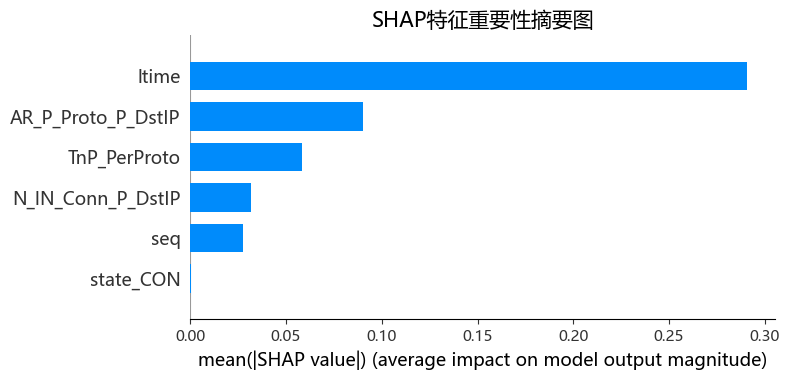

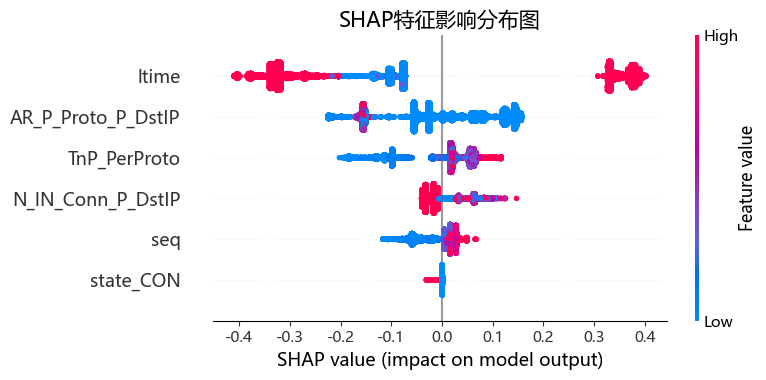

In [22]:
import matplotlib.pyplot as plt
import shap

# 绘制 SHAP 特征重要性摘要图
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, x_train, feature_names=x.columns, plot_type="bar", show=False)  # 设置 show=False 避免重复显示
plt.title("SHAP特征重要性摘要图", fontsize=15)
plt.tight_layout()
plt.savefig('基于SHAP值特征重要性.pdf', format='pdf')  # 保存为 PDF 格式
plt.show()

# 绘制 SHAP 特征影响分布图
plt.figure(figsize=(14,10))
shap.summary_plot(shap_values, x_train, feature_names=x.columns, show=False)  # 设置 show=False 避免重复显示
plt.title("SHAP特征影响分布图", fontsize=15)
plt.tight_layout()
plt.show()


In [23]:
for i in range(shap_values.shape[2]): # 假设 shap_values 是一个三维数组，第三维对应于类别
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values[:,:,i], x_train, feature_names=x.columns, plot_type="bar", show=False)
    plt.title(f"类别 {i} 的 SHAP 特征重要性摘要图", fontsize=15)
    plt.tight_layout()
    plt.show()

IndexError: tuple index out of range